In [3]:

import normflows as nf
from torch.optim import Adam
import tqdm
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

from tools.sde_lib import VESDE
from tools.loss import sde_score_matching_loss
from tools.sde_sampler import PC_sampler
from tools.sde_sampler import ode_sampler
from tools.likelihood import ode_likelihood
device='cuda'

In [4]:


class GaussianFourierProjection(nn.Module):
  """Gaussian random features for encoding time steps."""  
  def __init__(self, embed_dim, scale=30.):
    super().__init__()
    # Randomly sample weights during initialization. These weights are fixed 
    # during optimization and are not trainable.
    self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)
  def forward(self, x):
    x_proj = x[:, None] * self.W[None, :] * 2 * np.pi
    return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)


class LinearCond(nn.Module):
  """A fully connected layer that reshapes outputs to feature maps."""
  def __init__(self, input_dim, output_dim, embed_dim):
    super().__init__()
    self.x_lin = nn.Linear(input_dim, output_dim)
    self.embed_lim= nn.Linear(embed_dim, output_dim)
  def forward(self, x,embed):
    return self.x_lin(x) + self.embed_lim(embed)



class ScoreNet(nn.Module):
  """A score network that estimates the score of a trajectory."""
  def __init__(self, input_dim, embed_dim):

    super().__init__()
    self.embed = nn.Sequential(
      GaussianFourierProjection(embed_dim),
      nn.Linear(embed_dim, embed_dim),
    )

    self.linear1 = LinearCond(input_dim,128,embed_dim)
    self.linear2 = LinearCond(128,128,embed_dim)
    self.linear3 = LinearCond(128,128,embed_dim)
    self.output = nn.Linear(128,input_dim)

  def forward(self, x, t):
    emb = F.softplus(self.embed(t))

    x = self.linear1(x,emb)
    x = F.softplus(x)
    x = self.linear2(x,emb)
    x = F.softplus(x)
    x = self.linear3(x,emb)
    x = F.softplus(x)
    x = self.output(x)
    return x

In [17]:
test_sde=VESDE(sigma_min=0.01,sigma_max=0.5,N=100)

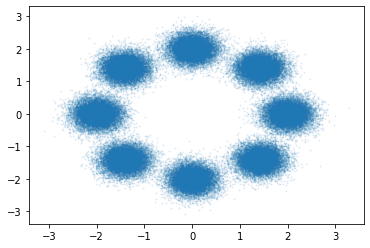

In [18]:
target = nf.distributions.CircularGaussianMixture()
data = target.sample(100000)

plt.scatter(data.numpy()[:,0], data.numpy()[:,1], s=1, alpha=0.1)

# from sklearn.datasets import make_swiss_roll
# def sample_batch(size, noise=0.5):
#     x, _= make_swiss_roll(size, noise=noise)
#     return x[:, [0, 2]] / 10.0
# data = sample_batch(10**4)
# data = torch.tensor(data).float()

# plt.scatter(data[:,0], data[:,1], s=1, alpha=0.1)

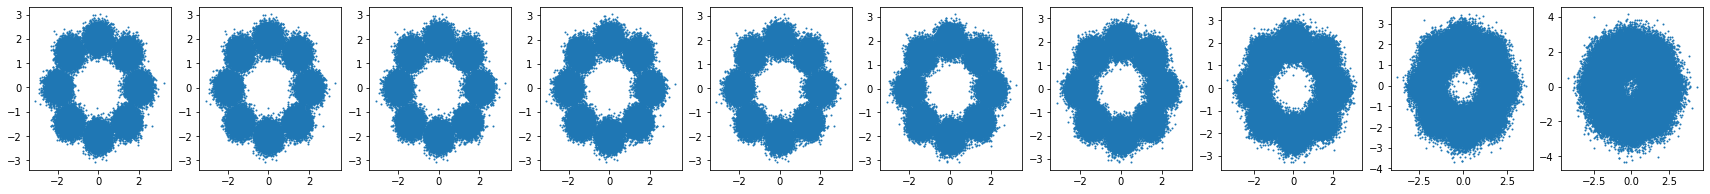

In [19]:
stds = test_sde.discrete_sigmas[np.linspace(0,99,10).astype(int)]
plt.figure(figsize=(30,3))
z = torch.randn_like(data)
for i,std in enumerate(stds):
    perturbed_x = data + z * std
    plt.subplot(1,10,i+1)
    plt.scatter(*perturbed_x.T,s=1)

In [20]:
score_model = ScoreNet(input_dim=2, embed_dim=4)
score_model = score_model.to(device)

n_epochs =   50
## size of a mini-batch
batch_size =  256

lr=1e-3

optimizer = Adam(score_model.parameters(), lr=lr)
tqdm_epoch = tqdm.notebook.trange(n_epochs)

dataset = torch.tensor(data, dtype=torch.float32).to(device)

for epoch in tqdm_epoch:
  avg_loss = 0.
  num_items = 0
  permutation = torch.randperm(dataset.size()[0])
  
  for i in range(0, dataset.size()[0], batch_size):
    indices = permutation[i:i+batch_size]
    batch_x = dataset[indices] 

    loss = sde_score_matching_loss(score_model, batch_x, test_sde)
    optimizer.zero_grad()
    loss.backward()    
    optimizer.step()
    avg_loss += loss.item() * batch_x.shape[0]
    num_items += batch_x.shape[0]
  # Print the averaged training loss so far.
  tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))
  # Update the checkpoint after each epoch of training.
  # torch.save(score_model.state_dict(), 'ckpt.pth')

  0%|          | 0/50 [00:00<?, ?it/s]

/tmp/ipykernel_3851262/3302002421.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dataset = torch.tensor(data, dtype=torch.float32).to(device)


(-3.0, 3.0)

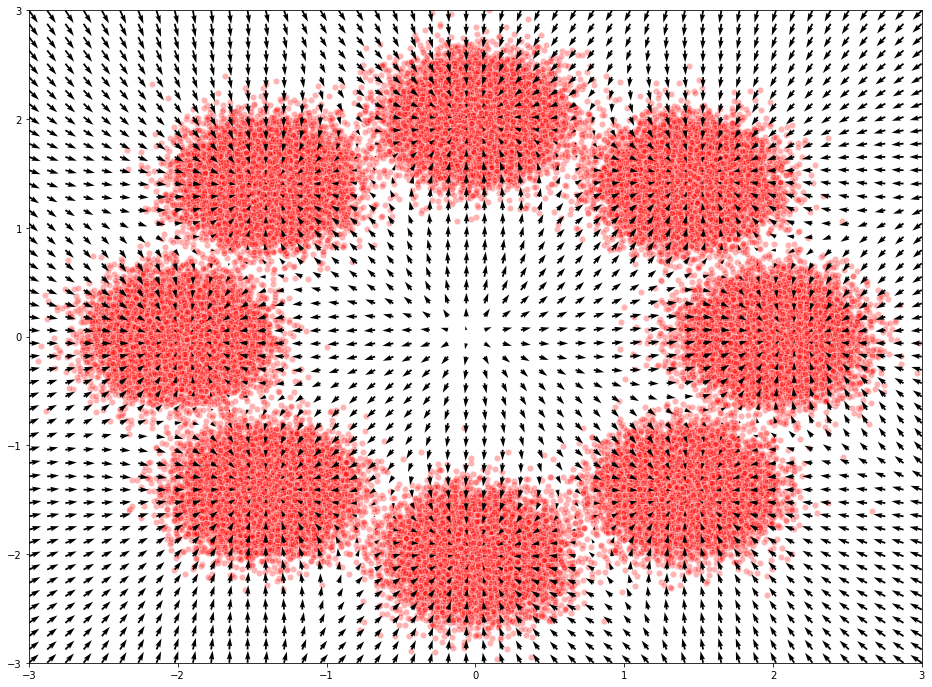

In [21]:
xx = np.stack(np.meshgrid(np.linspace(-3, 3.0, 50), np.linspace(-3, 3.0, 50)), axis=-1).reshape(-1, 2)
# xx = np.stack(np.meshgrid(np.linspace(-5, 5, 50), np.linspace(-5, 5, 50)), axis=-1).reshape(-1, 2)
times = torch.ones(xx.shape[0]).to(device)*1e-5
scores = score_model(torch.tensor(xx).float().to(device), times).detach().cpu().numpy()
scores_norm = np.linalg.norm(scores, axis=-1, ord=2, keepdims=True)
scores_log1p = scores / (scores_norm + 1e-9) * np.log1p(scores_norm)
# Perform the plots
plt.figure(figsize=(16,12))
plt.scatter(*data.T, alpha=0.3, color='red', edgecolor='white', s=40)
plt.quiver(*xx.T, *scores_log1p.T, width=0.002, color='black')
plt.xlim(-3, 3)
plt.ylim(-3, 3)

# plt.xlim(-5, 5)
# plt.ylim(-5, 5)

In [22]:
pc_sampler=PC_sampler(test_sde,score_model,n_correct_steps=1000,snr=1e-3)
test_samles=pc_sampler.sample(10000)

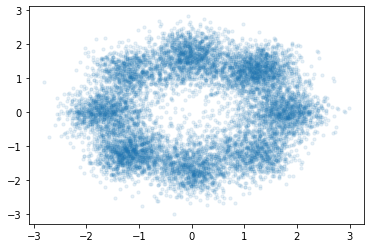

In [24]:
plt.scatter(*test_samles.cpu().T, s=10, alpha=0.1)

In [25]:
o_sampler=ode_sampler(test_sde,score_model)
test_osamples=o_sampler.sample(10000)[0]

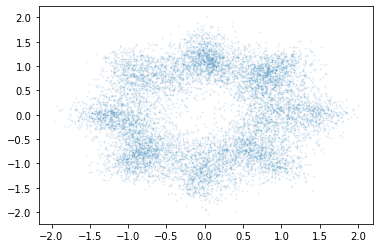

In [26]:
plt.scatter(*test_osamples.cpu().T, s=1, alpha=0.1)

In [27]:
o_likelihood= ode_likelihood(test_sde,score_model)

In [28]:
xx = np.stack(np.meshgrid(np.linspace(-3, 3.0, 50), np.linspace(-3, 3.0, 50)), axis=-1).reshape(-1, 2)

xx = torch.tensor(xx).float().to(device)
bpd = o_likelihood.likelihood_eval(xx)

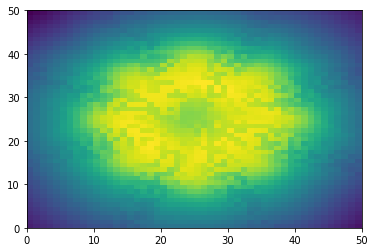

In [30]:
plt.pcolor(-np.log10(bpd.cpu().numpy().reshape(50,50)))